# Auto Mileage

In this problem, we will develop a model to predict whether a given car gets high or low gas mileage based on the Auto data set.

In [150]:
library(ISLR)
set.seed(1)

head(Auto)

Auto1=data.frame(Auto,mpg01=ifelse(Auto$mpg>median(Auto$mpg),1,0))

mpg,cylinders,displacement,horsepower,weight,acceleration,year,origin,name
18,8,307,130,3504,12.0,70,1,chevrolet chevelle malibu
15,8,350,165,3693,11.5,70,1,buick skylark 320
18,8,318,150,3436,11.0,70,1,plymouth satellite
16,8,304,150,3433,12.0,70,1,amc rebel sst
17,8,302,140,3449,10.5,70,1,ford torino
15,8,429,198,4341,10.0,70,1,ford galaxie 500


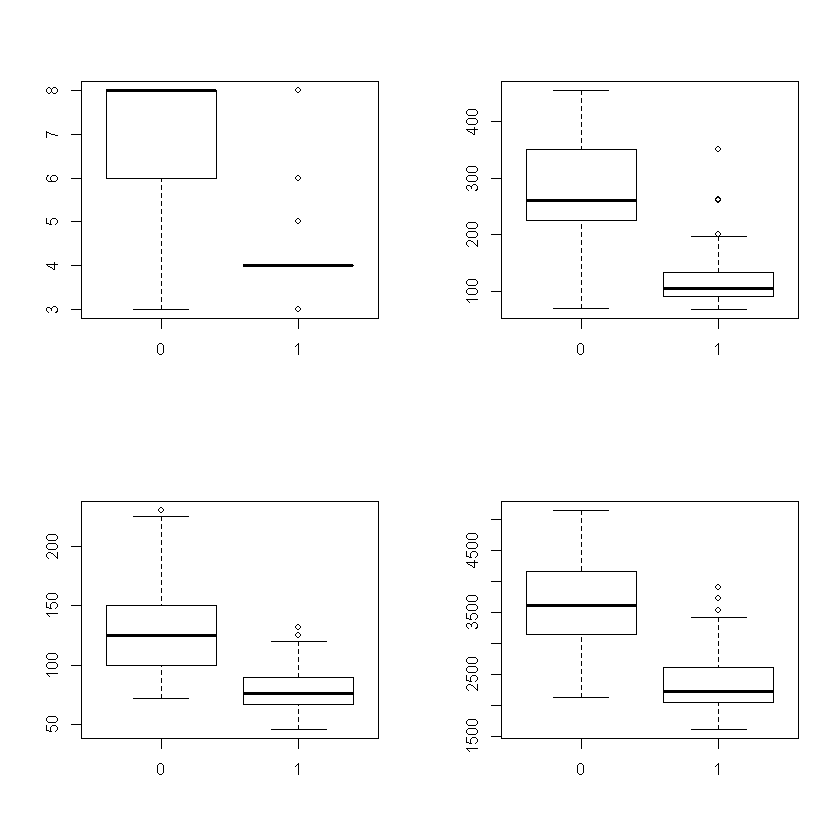

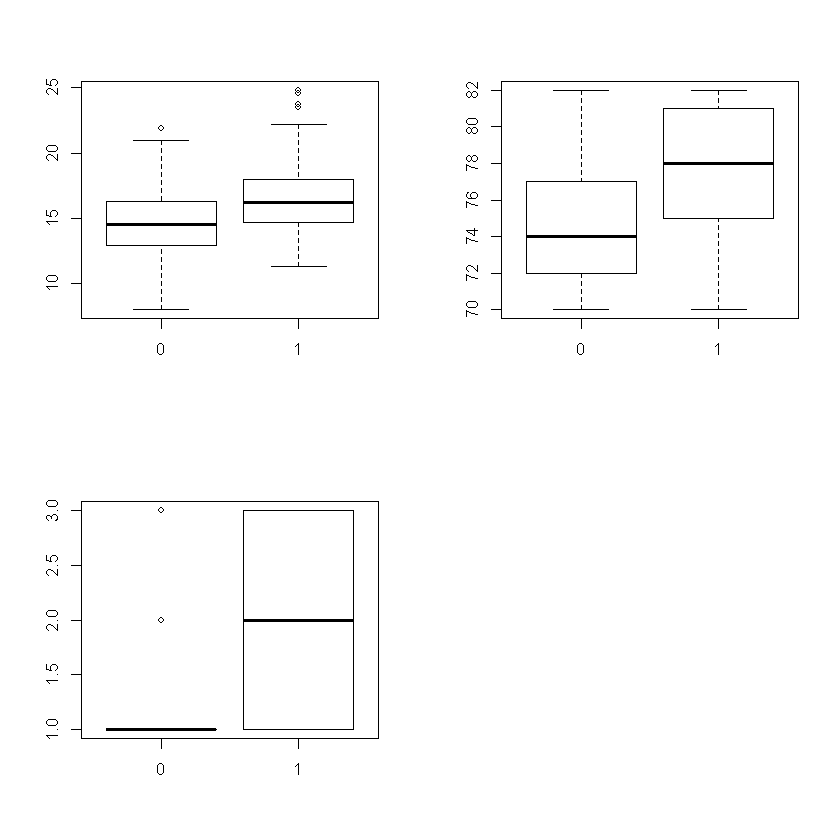

In [151]:
par("mfrow"=c(2,2))

boxplot(Auto1$cylinders~Auto1$mpg01)
boxplot(Auto1$displacement~Auto1$mpg01)
boxplot(Auto1$horsepower~Auto1$mpg01)
boxplot(Auto1$weight~Auto1$mpg01)
boxplot(Auto1$acceleration~Auto1$mpg01)
boxplot(Auto1$year~Auto1$mpg01)
boxplot(Auto1$origin~Auto1$mpg01)

MPG01 seems to be inversely proportional to Displacement, Cyl,HP, Wt. 

MPG01 seems to be proportional to accel, year, origin

First, lets create the helper functions

In [152]:
TPR=function(predicted,actual,positiveVal=1){
    tpr=sum(predicted==actual & predicted==positiveVal)/sum(actual==positiveVal)
    round(tpr*100,2)
}

TNR=function(predicted,actual,positiveVal=1){
    tnr=sum(predicted==actual & predicted!=positiveVal)/sum(actual!=positiveVal)
    round(tnr*100,2)
}

FPR=function(predicted,actual,positiveVal=1){
    fpr=sum(predicted!=actual & predicted==positiveVal)/sum(actual!=positiveVal)
    round(fpr*100,2)
}

FNR=function(predicted,actual,positiveVal=1){
    fnr=sum(predicted!=actual & predicted!=positiveVal)/sum(actual==positiveVal)
    round(fnr*100,2)
}

PPV=function(predicted,actual,positiveVal=1){
    ppv=sum(predicted==actual & predicted==positiveVal)/sum(predicted==positiveVal)
    round(ppv*100,2)
}

NPV=function(predicted,actual,positiveVal=1){
    npv=sum(predicted==actual & predicted!=positiveVal)/sum(predicted!=positiveVal)
    round(npv*100,2)
}

FDR=function(predicted,actual,positiveVal=1){
    fdr=sum(predicted!=actual & predicted==positiveVal)/sum(predicted==positiveVal)
    round(fdr*100,2)
}

FOR=function(predicted,actual,positiveVal=1){
    f.o.r=sum(predicted!=actual & predicted!=positiveVal)/sum(predicted!=positiveVal)
    round(f.o.r*100,2)
}

accuracy=function(predicted,actual,positiveVal=1){
    acc=sum(predicted==actual)/length(actual)
    round(acc*100,2)
}

confusionFigures=function(predicted,actual,name,positiveVal=1){
    data.frame(
        Name=name,
        algorithm=strsplit(name," ")[[1]][1],
        TPR=TPR(predicted,actual,positiveVal),
        TNR=TNR(predicted,actual,positiveVal),
        FPR=FPR(predicted,actual,positiveVal),
        FNR=FNR(predicted,actual,positiveVal),
        PPV=PPV(predicted,actual,positiveVal),
        NPV=NPV(predicted,actual,positiveVal),
        FDR=FDR(predicted,actual,positiveVal),
        FOR=FOR(predicted,actual,positiveVal),
        accuracy=accuracy(predicted,actual,positiveVal),
        TP=sum(predicted==actual & predicted==positiveVal),
        TN=sum(predicted==actual & predicted!=positiveVal),
        FP=sum(predicted!=actual & predicted==positiveVal),
        FN=sum(predicted!=actual & predicted!=positiveVal),
        population=length(predicted)
    );
}

# Simulate tossing a coin
coinToss=function(N,values=c(1,0)){
    l=length(values)
    values[ceiling(runif(N)*l)]
}

Let's create a training and testing set. Training set = 60% of data points, selected at random

In [153]:
N=length(Auto1$mpg01)
train=sample(1:N,round(60*N/100))
testData=Auto1[-train,]

# LDA

In [154]:
library(MASS)
lda.fit=lda(mpg01~cylinders+displacement
            +horsepower+weight+acceleration+year+origin,
            data=Auto1,subset = train)

lda.predict=predict(lda.fit,testData,type="response")
lda.class=lda.predict$class
cf=confusionFigures(lda.class,testData$mpg01,"LDA with default threshold")
confFig=cf

for(threshold in seq(0.1,1,by=0.1)){
    lda.class=ifelse(lda.predict$posterior[,2]>=threshold,1,0) 
    cf=confusionFigures(lda.class,testData$mpg01,paste("LDA with threshold ",threshold))
    confFig=rbind(confFig,cf)
}

confFig

Name,algorithm,TPR,TNR,FPR,FNR,PPV,NPV,FDR,FOR,accuracy,TP,TN,FP,FN,population
LDA with default threshold,LDA,100.00,84.81,15.19,0.00,86.67,100.00,13.33,0.00,92.36,78,67,12,0,157
LDA with threshold 0.1,LDA,100.00,63.29,36.71,0.00,72.90,100.00,27.10,0.00,81.53,78,50,29,0,157
LDA with threshold 0.2,LDA,100.00,75.95,24.05,0.00,80.41,100.00,19.59,0.00,87.90,78,60,19,0,157
LDA with threshold 0.3,LDA,100.00,79.75,20.25,0.00,82.98,100.00,17.02,0.00,89.81,78,63,16,0,157
LDA with threshold 0.4,LDA,100.00,82.28,17.72,0.00,84.78,100.00,15.22,0.00,91.08,78,65,14,0,157
LDA with threshold 0.5,LDA,100.00,84.81,15.19,0.00,86.67,100.00,13.33,0.00,92.36,78,67,12,0,157
LDA with threshold 0.6,LDA,100.00,87.34,12.66,0.00,88.64,100.00,11.36,0.00,93.63,78,69,10,0,157
LDA with threshold 0.7,LDA,98.72,88.61,11.39,1.28,89.53,98.59,10.47,1.41,93.63,77,70,9,1,157
LDA with threshold 0.8,LDA,96.15,91.14,8.86,3.85,91.46,96.00,8.54,4.00,93.63,75,72,7,3,157
LDA with threshold 0.9,LDA,84.62,93.67,6.33,15.38,92.96,86.05,7.04,13.95,89.17,66,74,5,12,157


# QDA

In [155]:
library(MASS)
qda.fit=qda(mpg01~cylinders+displacement
            +horsepower+weight+acceleration+year+origin,
            data=Auto1,subset = train)

qda.predict=predict(qda.fit,testData,type="response")

for(threshold in seq(0.1,1,by=0.1)){
    qda.class=ifelse(qda.predict$posterior[,2]>=threshold,1,0) 
    cf=confusionFigures(qda.class,testData$mpg01,paste("QDA with threshold ",threshold))
    confFig=rbind(confFig,cf)
}

confFig

Name,algorithm,TPR,TNR,FPR,FNR,PPV,NPV,FDR,FOR,accuracy,TP,TN,FP,FN,population
LDA with default threshold,LDA,100.00,84.81,15.19,0.00,86.67,100.00,13.33,0.00,92.36,78,67,12,0,157
LDA with threshold 0.1,LDA,100.00,63.29,36.71,0.00,72.90,100.00,27.10,0.00,81.53,78,50,29,0,157
LDA with threshold 0.2,LDA,100.00,75.95,24.05,0.00,80.41,100.00,19.59,0.00,87.90,78,60,19,0,157
LDA with threshold 0.3,LDA,100.00,79.75,20.25,0.00,82.98,100.00,17.02,0.00,89.81,78,63,16,0,157
LDA with threshold 0.4,LDA,100.00,82.28,17.72,0.00,84.78,100.00,15.22,0.00,91.08,78,65,14,0,157
LDA with threshold 0.5,LDA,100.00,84.81,15.19,0.00,86.67,100.00,13.33,0.00,92.36,78,67,12,0,157
LDA with threshold 0.6,LDA,100.00,87.34,12.66,0.00,88.64,100.00,11.36,0.00,93.63,78,69,10,0,157
LDA with threshold 0.7,LDA,98.72,88.61,11.39,1.28,89.53,98.59,10.47,1.41,93.63,77,70,9,1,157
LDA with threshold 0.8,LDA,96.15,91.14,8.86,3.85,91.46,96.00,8.54,4.00,93.63,75,72,7,3,157
LDA with threshold 0.9,LDA,84.62,93.67,6.33,15.38,92.96,86.05,7.04,13.95,89.17,66,74,5,12,157


# Log Reg

In [156]:
glm.fit=glm(mpg01~cylinders+displacement
            +horsepower+weight+acceleration+year+origin,
            data=Auto1,subset = train,family=binomial)


glm.probs=predict(glm.fit,testData,type="response")


for(threshold in seq(0.1,1,by=0.1)){
    glm.pred=rep(0,length(testData$mpg01))
    glm.pred[glm.probs>threshold]=1
    
    cf=confusionFigures(glm.pred,testData$mpg01,paste("Log Reg with threshold ",threshold))
    confFig=rbind(confFig,cf)
}

confFig

Name,algorithm,TPR,TNR,FPR,FNR,PPV,NPV,FDR,FOR,accuracy,TP,TN,FP,FN,population
LDA with default threshold,LDA,100.00,84.81,15.19,0.00,86.67,100.00,13.33,0.00,92.36,78,67,12,0,157
LDA with threshold 0.1,LDA,100.00,63.29,36.71,0.00,72.90,100.00,27.10,0.00,81.53,78,50,29,0,157
LDA with threshold 0.2,LDA,100.00,75.95,24.05,0.00,80.41,100.00,19.59,0.00,87.90,78,60,19,0,157
LDA with threshold 0.3,LDA,100.00,79.75,20.25,0.00,82.98,100.00,17.02,0.00,89.81,78,63,16,0,157
LDA with threshold 0.4,LDA,100.00,82.28,17.72,0.00,84.78,100.00,15.22,0.00,91.08,78,65,14,0,157
LDA with threshold 0.5,LDA,100.00,84.81,15.19,0.00,86.67,100.00,13.33,0.00,92.36,78,67,12,0,157
LDA with threshold 0.6,LDA,100.00,87.34,12.66,0.00,88.64,100.00,11.36,0.00,93.63,78,69,10,0,157
LDA with threshold 0.7,LDA,98.72,88.61,11.39,1.28,89.53,98.59,10.47,1.41,93.63,77,70,9,1,157
LDA with threshold 0.8,LDA,96.15,91.14,8.86,3.85,91.46,96.00,8.54,4.00,93.63,75,72,7,3,157
LDA with threshold 0.9,LDA,84.62,93.67,6.33,15.38,92.96,86.05,7.04,13.95,89.17,66,74,5,12,157


# KNN

In [157]:
library(class)
train.X=Auto1[train,c("cylinders","displacement","horsepower","weight","acceleration","year","origin")]
test.X=Auto1[-train,c("cylinders","displacement","horsepower","weight","acceleration","year","origin")]
train.mpg01=Auto1$mpg01[train]

set.seed(1)

In [158]:
for(K in seq(1:20)){
    knn.pred=knn(train.X,test.X,train.mpg01,k=K)
    cf=confusionFigures(knn.pred,Auto1$mpg01[-train],paste("KNN K=",K))
    confFig=rbind(confFig,cf)    
}

# Final Results

In [159]:
confFig
    
cat("\nOverall Accuracy")
summary(confFig$accuracy)

cat("\nAlgorithm Accuracy")
tapply(confFig$accuracy,confFig$algorithm,summary)

Name,algorithm,TPR,TNR,FPR,FNR,PPV,NPV,FDR,FOR,accuracy,TP,TN,FP,FN,population
LDA with default threshold,LDA,100.00,84.81,15.19,0.00,86.67,100.00,13.33,0.00,92.36,78,67,12,0,157
LDA with threshold 0.1,LDA,100.00,63.29,36.71,0.00,72.90,100.00,27.10,0.00,81.53,78,50,29,0,157
LDA with threshold 0.2,LDA,100.00,75.95,24.05,0.00,80.41,100.00,19.59,0.00,87.90,78,60,19,0,157
LDA with threshold 0.3,LDA,100.00,79.75,20.25,0.00,82.98,100.00,17.02,0.00,89.81,78,63,16,0,157
LDA with threshold 0.4,LDA,100.00,82.28,17.72,0.00,84.78,100.00,15.22,0.00,91.08,78,65,14,0,157
LDA with threshold 0.5,LDA,100.00,84.81,15.19,0.00,86.67,100.00,13.33,0.00,92.36,78,67,12,0,157
LDA with threshold 0.6,LDA,100.00,87.34,12.66,0.00,88.64,100.00,11.36,0.00,93.63,78,69,10,0,157
LDA with threshold 0.7,LDA,98.72,88.61,11.39,1.28,89.53,98.59,10.47,1.41,93.63,77,70,9,1,157
LDA with threshold 0.8,LDA,96.15,91.14,8.86,3.85,91.46,96.00,8.54,4.00,93.63,75,72,7,3,157
LDA with threshold 0.9,LDA,84.62,93.67,6.33,15.38,92.96,86.05,7.04,13.95,89.17,66,74,5,12,157



Overall Accuracy

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  50.32   85.99   87.26   86.35   91.72   93.63 


Algorithm Accuracy

$LDA
   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  50.32   88.54   91.08   86.86   93.00   93.63 

$QDA
   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  50.32   90.13   91.40   87.13   91.72   92.99 

$Log
   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  50.32   85.82   90.13   85.73   92.20   92.36 

$KNN
   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  81.53   85.99   85.99   85.99   86.62   87.26 


* For LDA, the best performing is 0.6-0.8. There is some flexibility to choose the threshold based on whether we want to minimize FPR or FNR. Four of the top 5, all of the top 3 are LDA
* QDA is close behind top quartile, but not the best. The best threshold is 0.7, which is also in the LDA range of 0.6-0.8. The 4th best is indeed QDA
* Log is best at 0.2,0.6 and 0.7
* KNN is the worst here, and the best results come at K=7 and 20

,Name,algorithm,TPR,TNR,FPR,FNR,PPV,NPV,FDR,FOR,accuracy,TP,TN,FP,FN,population
7,LDA with threshold 0.6,LDA,100.00,87.34,12.66,0.00,88.64,100.00,11.36,0.00,93.63,78,69,10,0,157
8,LDA with threshold 0.7,LDA,98.72,88.61,11.39,1.28,89.53,98.59,10.47,1.41,93.63,77,70,9,1,157
9,LDA with threshold 0.8,LDA,96.15,91.14,8.86,3.85,91.46,96.00,8.54,4.00,93.63,75,72,7,3,157
18,QDA with threshold 0.7,QDA,97.44,88.61,11.39,2.56,89.41,97.22,10.59,2.78,92.99,76,70,9,2,157
1,LDA with default threshold,LDA,100.00,84.81,15.19,0.00,86.67,100.00,13.33,0.00,92.36,78,67,12,0,157


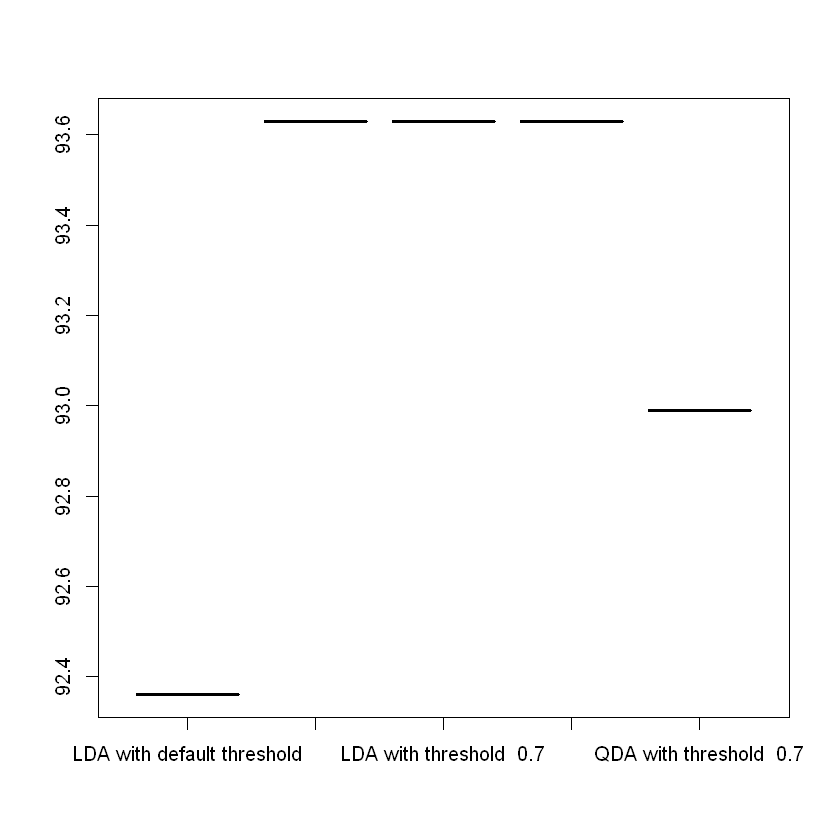

In [162]:
top5=head(confFig[order(confFig$accuracy, decreasing=TRUE), ], 5)

top5$Name=factor(top5$Name)
top5
plot(top5$Name,top5$accuracy)